In [0]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from nltk.stem.porter import PorterStemmer
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import LSTM, Conv1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
movie_reviews = pd.read_csv("/content/drive/My Drive/IMDB Dataset.csv")

In [6]:
movie_reviews.isnull().values.any()
movie_reviews.shape

(50000, 2)

In [7]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


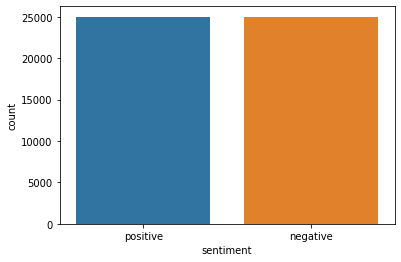

In [9]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

In [0]:
#DATA PREPROCESSING

In [0]:
tag = re.compile(r'<[^>]+>')
def remove_tags(text):
    return tag.sub('',text)

In [0]:
def preprocess(sen):
    #removing html tags
    sentence = remove_tags(sen)

    #split into words
    tokens = word_tokenize(sentence)

    #filtering punctuation
    words = [word for word in tokens if word.isalpha()]

    #filtering stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]

    #stem words
    #porter = PorterStemmer()
    #stemmed = [porter.stem(word) for word in words]

    #joining together
    sentence = ' '.join(words)

    #removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence


In [0]:
#iterating through all the reviews
X = []
sentences = list(movie_reviews["review"])
for sen in sentences:
    X.append(preprocess(sen))

In [14]:
X[3]

'Basically family little boy Jake thinks zombie closet parents fighting movie slower soap opera suddenly Jake decides become Rambo kill first going make film must Decide thriller drama As drama movie watchable Parents divorcing arguing like real life And Jake closet totally ruins film I expected see BOOGEYMAN similar movie instead watched drama meaningless thriller well playing parents descent dialogs As shots Jake ignore'

In [0]:
y = movie_reviews["sentiment"]
y = np.array(list(map(lambda x: 1 if x=='positive' else 0, y)))

In [0]:
#splitting into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Embedding Layer

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [18]:
print(len(X_train[1]))

122


In [0]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/My Drive/glove_embed/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [0]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#**Using a Conv Net for text classification**

In [0]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [33]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          8999200   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 92, 64)            41024     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,104,417
Trainable params: 105,217
Non-trainable params: 8,999,200
_________________________________________________________________
None


In [34]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 9s 274us/step - loss: 0.4751 - acc: 0.7669 - val_loss: 0.3905 - val_acc: 0.8260
Epoch 2/6
32000/32000 [==============================] - 2s 54us/step - loss: 0.3619 - acc: 0.8400 - val_loss: 0.3590 - val_acc: 0.8393
Epoch 3/6
32000/32000 [==============================] - 2s 53us/step - loss: 0.3175 - acc: 0.8631 - val_loss: 0.3511 - val_acc: 0.8484
Epoch 4/6
32000/32000 [==============================] - 2s 53us/step - loss: 0.2729 - acc: 0.8892 - val_loss: 0.3446 - val_acc: 0.8521
Epoch 5/6
32000/32000 [==============================] - 2s 53us/step - loss: 0.2316 - acc: 0.9087 - val_loss: 0.3490 - val_acc: 0.8497
Epoch 6/6
10000/10000 [==============================] - 1s 74us/step


In [35]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3773821232318878
Test Accuracy: 0.8428999781608582


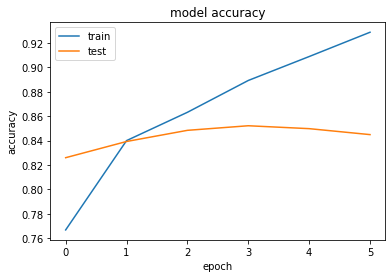

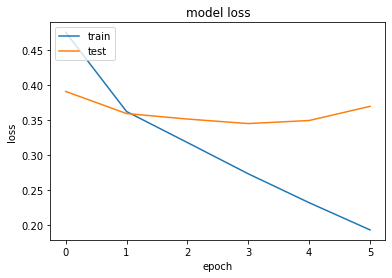

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()